### Building image classification

In [29]:
import os, cv2, random, pickle
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras import layers, models, optimizers
from keras import applications
from keras import backend as K
from sklearn.model_selection import train_test_split

- The images were provided in the `DICOM` format, which is the medical industry standard for body scans. This proved to be problematic while processing the images, so I were converted to a more suitable file format (`PNG`) before being used in my model.
- The images were initially converted to a resolution of `1024x1024`, but this proved to be problematic for the my machine (laptop). Thus, I resized to `180x180` to process the images effectively.

In [2]:
img_size = 180
normal_dir = './data/normal/'
pneumonia_dir = './data/pneumonia/'

- I have only used only a portion of the images for demonstration purpose.
- I were randomly sampling 6000 images from the `normal` images file. The reason for this is to make balance training set since the number of `pneumonia` images are around more than 6000 images. 

In [3]:
train_normal = random.sample([normal_dir + i for i in os.listdir(normal_dir)], 6000)
train_pneumonia = [pneumonia_dir + i for i in os.listdir(pneumonia_dir)]

In [4]:
def prepare_data(list_of_images_0, list_of_images_1):
    """
    Returns two arrays: 
        X is an array of resized images
        y is an array of labels
    """
    X = [] # images as arrays
    y = [] # labels
    
    for image in list_of_images_0:
        X.append(cv2.resize(cv2.imread(image), (img_size,img_size), interpolation=cv2.INTER_CUBIC))
    for i in list_of_images_0:
        y.append(0)
    
    for image in list_of_images_1:
        X.append(cv2.resize(cv2.imread(image), (img_size,img_size), interpolation=cv2.INTER_CUBIC))
    for i in list_of_images_1:
        y.append(1)
            
    return X, y

```python
X, y = prepare_data(train_normal, train_pneumonia)
print(K.image_data_format())
```

__Save the data to `pickle`__
```python
pickle_out = open('X.pickle', 'wb')
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open('y.pickle', 'wb')
pickle.dump(y, pickle_out)
pickle_out.close()
```

__Open the `pickle` data file__

In [5]:
pickle_in = open('X.pickle','rb')
X = pickle.load(pickle_in)

In [6]:
pickle_in = open('y.pickle','rb')
y = pickle.load(pickle_in)

In [7]:
X[0].shape

(180, 180, 3)

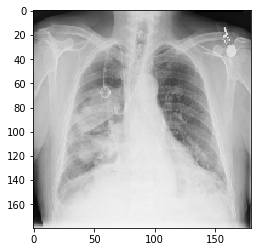

In [8]:
plt.imshow(X[0])

- Split the data in two sets, 90% for training, 10% for validation.

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=101)

__Data augmentation__
- `rescale`: The original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so I target values between 0 and 1 instead by scaling with a 1/255. factor.
- `shear_range` is for randomly applying shearing transformations.
- `zoom_range` is for randomly zooming inside pictures.
- `horizontal_flip` is for randomly flipping half of the images horizontally.

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

- Instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)`.
- This generator can then be used with the Keras model methods that accept data generators as inputs, `fit_generator`, `evaluate_generator` and `predict_generator`.

In [12]:
# This is the augmentation configuration we will use for training
train_generator = train_datagen.flow(np.array(X_train), y_train, batch_size=batch_size)

# This is a similar generator, for validation data
validation_generator = val_datagen.flow(np.array(X_val), y_val, batch_size=batch_size)

__Training the model__


- I used simple image classification to gain a foundation and understanding on how I could utilize a convolution neural network to correctly classify pneumonia.
- A simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers.
- On top of it I stick two fully-connected layers. I end the model with a single unit and a `sigmoid` activation, which is perfect for a binary classification. To go with it I will also use the `binary_crossentropy` loss to train our model.

In [13]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(img_size, img_size, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 178, 178, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 87, 87, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 41, 41, 64)        18496     
__________

In [10]:
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
batch_size = 16

In [14]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = 10,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/10
675/675 [==============================] - 422s 626ms/step - loss: 0.6308 - acc: 0.6640 - val_loss: 0.5693 - val_acc: 0.7175
Epoch 2/10
675/675 [==============================] - 433s 642ms/step - loss: 0.5889 - acc: 0.7098 - val_loss: 0.5488 - val_acc: 0.7344
Epoch 3/10
675/675 [==============================] - 443s 656ms/step - loss: 0.5753 - acc: 0.7159 - val_loss: 0.6142 - val_acc: 0.6720
Epoch 4/10
675/675 [==============================] - 439s 651ms/step - loss: 0.5680 - acc: 0.7230 - val_loss: 0.5467 - val_acc: 0.7268
Epoch 5/10
675/675 [==============================] - 456s 676ms/step - loss: 0.5615 - acc: 0.7336 - val_loss: 0.5319 - val_acc: 0.7352
Epoch 6/10
675/675 [==============================] - 442s 655ms/step - loss: 0.5624 - acc: 0.7257 - val_loss: 0.5502 - val_acc: 0.7344
Epoch 7/10
675/675 [==============================] - 417s 618ms/step - loss: 0.5611 - acc: 0.7286 - val_loss: 0.5419 - val_acc: 0.7352
Epoch 8/10
675/675 [============================

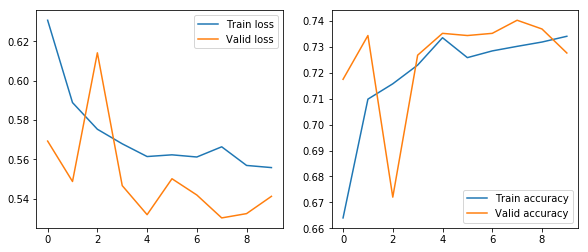

In [23]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()

In [24]:
model.save_weights('first_try.h5')
model.save('first_try_keras.h5')

- This approach gets me to a validation accuracy of __0.72 - 0.73__ after 10 epochs. It does not seen to be overfitting too much by now.
- Each epoch takes 400-450s on my machine (laptop).
- The variance of the validation accuracy is quite high, both because accuracy is a high-variance metric and because I only use 600 images (10% of all images).
- In the next approach I will use the pre-trained model (VGG16).

__Using a pre-trained network__

- I will use the VGG16 architecture, pre-trained on the ImageNet dataset.
- Here's what the VGG16 architechture looks like:

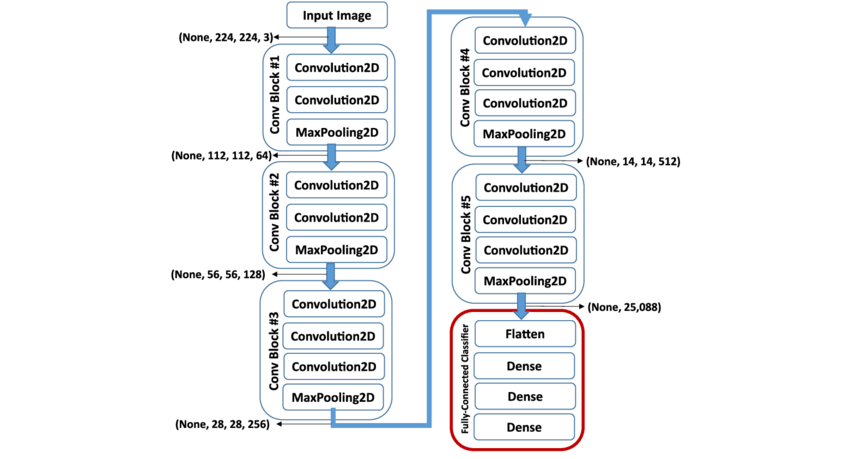

- My strategy will be as follow: I will only instantiate the convolutional part of the model, everything up to the fully-connected layers. I will then run this model on our training and validation data once, recording the output (the "bottleneck features" from the VGG16 model: the last activation maps before the fully-connected layers) in two numpy arrays. Then I will train a small fully-connected model on top of the stored features.
-  Running VGG16 is expensive, especially if you're working on CPU, and I want to only do it once. Thus, I will use `google colaboratory` for training model.

__You can find the full code for this approach [here](https://colab.research.google.com/drive/1uGHBHIlLFOMii5572EatYbPpFP3Ibghq)__